# Simple iteration for systems of linear equations

First, generate a random diagonally dominant matrix, for testing.

In [1404]:
import numpy as np
from matplotlib import pyplot as plt
rndm = np.random.RandomState(1234)

n = 5
A = rndm.uniform(size=(n, n)) + np.diagflat([15]*n)
b = rndm.uniform(size=n)

# I.  Jacobi iteration

Given

$$
A x = b
$$

separate the diagonal part $D$,

$$ A = D + (A - D) $$

and write

$$
x = D^{-1} (D - A) x + D^{-1} b\;.
$$

Then iterate

$$
x_{n + 1} = B x_{n} + c\;,
$$

where 

$$
B = D^{-1} (D - A) \qquad \text{and} \qquad c = D^{-1} b
$$


Let's construct the matrix and the r.h.s. for the Jacobi iteration

In [1405]:
diag_1d = np.diag(A)

B = -A.copy()
np.fill_diagonal(B, 0)

D = np.diag(diag_1d)
invD = np.diag(1./diag_1d)
BB = invD @ B 
c = invD @ b

In [1406]:
# sanity checks
from numpy.testing import assert_allclose

assert_allclose(-B + D, A)


# xx is a "ground truth" solution, compute it using a direct method
xx = np.linalg.solve(A, b)

np.testing.assert_allclose(A@xx, b)
np.testing.assert_allclose(D@xx, B@xx + b)
np.testing.assert_allclose(xx, BB@xx + c)

Check that $\| B\| \leqslant 1$:

In [1407]:
np.linalg.norm(BB)

0.17396672093190155

### Do the Jacobi iteration

In [1408]:
n_iter = 50

x0 = np.ones(n)
x = x0
for _ in range(n_iter):
    x = BB @ x + c

In [1409]:
# Check the result:

A @ x - b

array([1.11022302e-16, 5.55111512e-17, 0.00000000e+00, 0.00000000e+00,
       1.11022302e-16])

### Task I.1

Collect the proof-of-concept above into a single function implementing the Jacobi iteration. This function should receive the r.h.s. matrix $A$, the l.h.s. vector `b`, and the number of iterations to perform.


The matrix $A$ in the illustration above is strongly diagonally dominant, by construction. 
What happens if the diagonal matrix elements of $A$ are made smaller? Check the convergence of the Jacobi iteration, and check the value of the norm of $B$.

(20% of the total grade)


In [1410]:
def jacobi_iteration(a, b, x0, ni=50):
    '''Use the Jacobi iteration method

    Parameters
    ----------
    a : np.ndarray
        r.h.s. matrix.
    b : np.ndarray 
        l.h.s. matrix.
    x0 : np.ndarray
        Initial answer array for Jacobi Iteration algorythm
    ni : integer
        The number of iterations to perform.

    Returns
    ----------
    x : ndarray
        The solution of A @ x == b equation.

    '''
    d_temp = np.diag(a)
    D = np.diag(d_temp)
    D_inverse = np.diag(1.0 / d_temp)
    B_temp = D.copy() - A.copy()
    B = D_inverse @ B_temp
    c = D_inverse @ b
    x = x0
    for _ in range(ni):
        x = B @ x + c
    return x

In [1411]:
x_j = jacobi_iteration(A, b, np.ones(n))
dif_j = A @ x_j - b
dif_j

array([1.11022302e-16, 5.55111512e-17, 0.00000000e+00, 0.00000000e+00,
       1.11022302e-16])

# II. Seidel's iteration.

##### Task II.1

Implement the Seidel's iteration. 

Test it on a random matrix. Study the convergence of iterations, relate to the norm of the iteration matrix.

(30% of the total grade)

In [1412]:
def seidels_iteration(a, b, x0, ni=50):
    '''Use the Seidel\'s iteration method to solve a linear system of equations.

    Parameters
    ----------
    a : np.ndarray
        r.h.s. matrix.
    b : np.ndarray 
        l.h.s. matrix.
    x0 : np.ndarray
        Initial answer array for Jacobi Iteration algorythm
    ni : integer
        The number of iterations to perform.

    Returns
    ----------
    x : ndarray
        The solution of A @ x == b equation.

    '''
    L = np.tril(a)
    U = np.triu(a, 1)
    x = x0
    for _ in range(ni):
        x = np.linalg.inv(L) @ (b - U @ x)
    return x

In [1413]:
x_s = seidels_iteration(A, b, np.ones(n))
dif_s = A @ x_s - b
dif_s

array([1.11022302e-16, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

In [1414]:
abs(dif_j) - abs(dif_s)

array([0.00000000e+00, 5.55111512e-17, 0.00000000e+00, 0.00000000e+00,
       1.11022302e-16])

# III. Minimum residual scheme

### Task III.1

Implement the $\textit{minimum residual}$ scheme: an explicit non-stationary method, where at each step you select the iteration parameter $\tau_n$ to minimize the residual $\mathbf{r}_{n+1}$ given $\mathbf{r}_n$. Test it on a random matrix, study the convergence to the solution, in terms of the norm of the residual and the deviation from the ground truth solution (which you can obtain using a direct method). Study how the iteration parameter $\tau_n$ changes as iterations progress.

(50% of the grade)

In [1415]:
def minimal_residual(A, b, x0, ni=50):
    x = x0
    i = -1
    tau_arr = np.zeros(ni)
    for i in range(ni):
        r = A @ x - b
        A_f = A @ r
        if np.linalg.norm(r) > 0:
            #print(r.T)
            tau = r.T @ A_f / np.linalg.norm(A_f) ** 2
            tau_arr[i] = tau
            #print(tau_arr)
            #print('tau: {}'.format(tau))
            x -= tau * r
        else:
            break
    return x, tau_arr

In [1416]:
#print(np.ones(n))
x_m, tau_arr = minimal_residual(A, b, np.ones(n))
dif_s = A @ x_m - b
dif_s

array([0., 0., 0., 0., 0.])

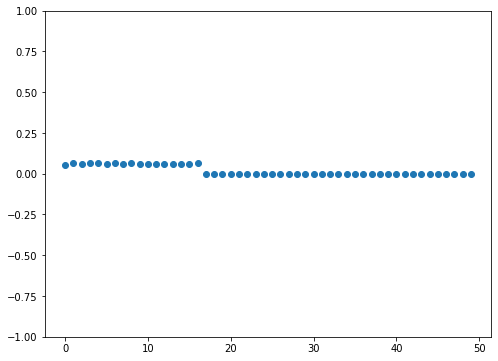

In [1417]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(tau_arr.size), tau_arr, 'o')
plt.ylim(-1, 1)
plt.show()

In [1418]:
n = 3
a = np.random.uniform(size=(n, n)) + np.diagflat([15]*n)
b = np.random.uniform(size=n)
x_m, tau_arr = minimal_residual(a, b, np.ones(n))
dif_s = a @ x_m - b
np.linalg.norm(dif_s)

0.0

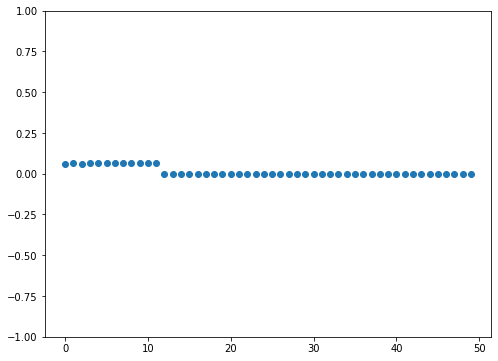

In [1419]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(tau_arr.size), tau_arr, 'o')
plt.ylim(-1, 1)
plt.show()